In [1]:
import numpy as np
import random
from collections import Counter

In [2]:
########读取机器学习数据集的示例代码 (LIBSVM格式)
def load_svmfile(filename):
    X = []
    Y = []
    with open(filename, 'r') as f:
        filelines = f.readlines()
        for fileline in filelines:
            fileline = fileline.strip().split(' ')
            #print(fileline)
            Y.append(int(fileline[0]))
            tmp = []
            for t in fileline[1:]:
                if len(t)==0:
                    continue
                tmp.append(float(t.split(':')[1]))
            X.append(tmp)
    
    return np.array(X), np.array(Y)

In [3]:
########从这个网址下载数据集：https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#svmguide1
########将数据集保存在当前目录下
########读取数据集
dataset = 'svmguide1'
print('Start loading dataset {}'.format(dataset))
X, Y = load_svmfile(dataset) # train set
X_test, Y_test = load_svmfile('{}.t'.format(dataset)) # test set
print('trainset X shape {}, train label Y shape {}'.format(X.shape, Y.shape))
print('testset X_test shape {}, test label Y shape {}'.format(X_test.shape, Y_test.shape))

Start loading dataset svmguide1
trainset X shape (3089, 4), train label Y shape (3089,)
testset X_test shape (4000, 4), test label Y shape (4000,)


In [4]:
########实现一个KNN分类器的模型，需要完成的功能包括train, test和_calculate_distances三部分
class KNN_model():
    def __init__(self, k=1):
        self.k = k
    
    def train(self, x_train, y_train):
        """Implement the training code for KNN
        Input: 
            x_train: Training instances of size (N, D), where N denotes the number of instances and D denotes the feature dimension
            y_train: Training labels of size (N, )
        """
        self.x_train = x_train
        self.y_train = y_train
    
    def test(self, x_test):
        """
        Input: Test instances of size (N, D), where N denotes the number of instances and D denotes the feature dimension
        Return: Predicted labels of size (N, )
        """
        # 计算出所有的样本的距离
        distances = np.array([self._calculate_distances(x_test_sample) for x_test_sample in x_test])
        # 每个样本 k 个最近邻对应的下标
        indices = np.argsort(distances)[:, :self.k]
        # 每个样本 k 个最近邻对应的类别
        labels = self.y_train[indices]
        # 通过投票得到次数最多的类别
        y_pred = np.array([Counter(labels_for_one).most_common()[0][0] for labels_for_one in labels])
        return y_pred

    def _calculate_distances(self, point):
        """Calculate the euclidean distance between a test instance and all points in the training set x_train
        Input: a single point of size (D, )
        Return: distance matrix of size (N, )
        """
        return ((self.x_train - point) ** 2).sum(axis=1) ** 0.5

# m = KNN_model(k=1)
# m.train(np.array([[0, 0, 0], [1, 1, 1], [2, 2, 2]]), np.array([0, 1, 0]))
# print(m._calculate_distances(np.array([0, 0, 0])))
# print(m.test(np.array([[0, 0, 0], [0, 1, 1]])))

In [5]:
######### 将原来的训练集划分成两部分：训练和验证
random.seed(777777) #定下随机种子
N = X.shape[0] 
valid_frac = 0.2 # 设置验证集的比例为20%
valid_size = int(N*valid_frac)

# 出于简单起见，这里直接使用random shuffle来划分
shuffle_index = [i for i in range(N)]
random.shuffle(shuffle_index)
valid_index, train_index = shuffle_index[:valid_size], shuffle_index[valid_size:]
X_valid, Y_valid = X[valid_index], Y[valid_index]
X_train, Y_train = X[train_index], Y[train_index]
print('trainset X_train shape {}, validset X_valid shape {}'.format(X_train.shape, X_valid.shape))

trainset X_train shape (2472, 4), validset X_valid shape (617, 4)


In [6]:
######### 这里需要实现计算准确率的函数，注意我们期望的输出是百分制，如准确率是0.95，我们期望的输出是95
def cal_accuracy(y_pred, y_gt):
    '''
    y_pred: predicted labels (N,)
    y_gt: ground truth labels (N,)
    Return: Accuracy (%)
    '''
    return np.sum(y_pred == y_gt) / y_gt.shape[0] * 100
assert abs(cal_accuracy(np.zeros(Y.shape[0]), Y)-100*1089.0/3089.0)<1e-3

k=1, accuracy on validation=96.27228525121556%
k=3, accuracy on validation=96.27228525121556%
k=5, accuracy on validation=96.27228525121556%
k=7, accuracy on validation=96.43435980551054%
k=9, accuracy on validation=96.11021069692059%
k=11, accuracy on validation=95.62398703403565%


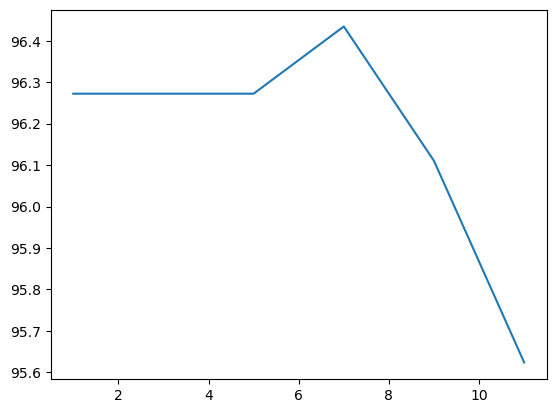

In [7]:
#####使用验证集来选择超参数
possible_k_list = [1,3,5,7,9,11] # 在本次实验中候选的超参数取值
accs = [] # 将每个取值k对应的验证集准确率加入列表
for k in possible_k_list:
    #####模型的超参数设置为k
    model = KNN_model(k)
    #####在训练集上训练, 提示: model.train()
    model.train(X_train, Y_train)
    #####在验证集X_valid上给出预测结果 Y_pred_valid, 提示：model.test()
    Y_pred_valid = model.test(X_valid)
    #####计算验证集上的准确率
    acc_k = cal_accuracy(Y_pred_valid, Y_valid)
    #####将每个取值k对应的验证集准确率加入列表
    accs.append(acc_k)
    print('k={}, accuracy on validation={}%'.format(k, acc_k))

import matplotlib.pyplot as plt
plt.plot(possible_k_list, accs) #画出每个k对应的验证集准确率

In [8]:
#####基于上面的结果确定验证集上的最好的超参数k，根据这个k最终在测试集上进行测试
best_k = 7

#####定义最好的k对应的模型
best_model = KNN_model(best_k)

#####在训练集上训练，注意这里可以使用全部的训练数据
best_model.train(X, Y)

#####在测试集上测试生成预测 Y_pred_test
Y_pred_test = best_model.test(X_test)
print('Test Accuracy={}%'.format(cal_accuracy(Y_pred_test, Y_test)))

Test Accuracy=96.575%


In [9]:
#####以下需要实现5折交叉验证，可以参考之前训练集和验证集划分的方式
folds = 5

#####(k, 均值, 方差) 列表
k_mean_std_list = []

for k in possible_k_list: # 遍历所有可能的k
    print('******k={}******'.format(k))
    valid_accs = []

    ######### 将原来的训练集划分成两部分：训练和验证
    random.seed(777777) #定下随机种子
    N = X.shape[0] 
    valid_frac = 1 / folds  # 设置验证集的比例为 1/folds
    valid_size = int(N * valid_frac)

    # 出于简单起见，这里直接使用random shuffle来划分
    shuffle_index = [i for i in range(N)]
    random.shuffle(shuffle_index)
    shuffle_X, shuffle_Y = X[shuffle_index], Y[shuffle_index]
    for i in range(folds): # 第i折的实验
        ##### 生成第i折的训练集 X_train_i, Y_train_i和验证集 X_valid_i, Y_valid_i; 提示：可参考之前random shuffle的方式来生成index
        X_valid_i, Y_valid_i = X[i * valid_size: (i+1) * valid_size], Y[i * valid_size: (i+1) * valid_size]
        X_train_i = np.vstack((X[:i * valid_size], X[(i+1) * valid_size:]))
        Y_train_i = np.append(Y[:i * valid_size], Y[(i+1) * valid_size:])
        ##### 定义超参数设置为k的模型
        model = KNN_model(k)
        ##### 在Fold-i上进行训练
        model.train(X_train_i, Y_train_i)
        ##### 给出Fold-i验证集X_valid_i上的预测结果 Y_pred_valid_i
        Y_pred_valid_i = model.test(X_valid_i)
        acc = cal_accuracy(Y_pred_valid_i, Y_valid_i)
        valid_accs.append(acc)
        print('Valid Accuracy on Fold-{}: {}%'.format(i+1, acc))
    
    k_mean_std_list.append((k, np.mean(valid_accs), np.std(valid_accs)))
    print('k={}, Accuracy {}+-{}%'.format(*k_mean_std_list[len(k_mean_std_list) - 1]))

print('k_mean_std_list:', k_mean_std_list)

******k=1******
Valid Accuracy on Fold-1: 96.11021069692059%
Valid Accuracy on Fold-2: 95.78606158833063%
Valid Accuracy on Fold-3: 96.75850891410049%
Valid Accuracy on Fold-4: 88.49270664505673%
Valid Accuracy on Fold-5: 92.70664505672609%
k=1, Accuracy 93.9708265802269+-3.0741232335892827%
******k=3******
Valid Accuracy on Fold-1: 96.27228525121556%
Valid Accuracy on Fold-2: 95.78606158833063%
Valid Accuracy on Fold-3: 97.24473257698541%
Valid Accuracy on Fold-4: 90.76175040518638%
Valid Accuracy on Fold-5: 93.67909238249594%
k=3, Accuracy 94.74878444084278+-2.3094344415632944%
******k=5******
Valid Accuracy on Fold-1: 96.75850891410049%
Valid Accuracy on Fold-2: 96.27228525121556%
Valid Accuracy on Fold-3: 97.08265802269044%
Valid Accuracy on Fold-4: 91.24797406807131%
Valid Accuracy on Fold-5: 93.03079416531604%
k=5, Accuracy 94.87844408427875+-2.320780851820909%
******k=7******
Valid Accuracy on Fold-1: 96.5964343598055%
Valid Accuracy on Fold-2: 96.5964343598055%
Valid Accuracy o

In [10]:
#####基于交叉验证确定验证集上的最好的超参数k，根据这个k最终在测试集上进行测试
best_k = 7
#####定义最好的k对应的模型
best_model = KNN_model(best_k)
#####在训练集上训练，注意这里可以使用全部的训练数据
best_model.train(X, Y)
#####在测试集上测试生成预测 Y_pred_test
Y_pred_test = best_model.test(X_test)
print('Test Accuracy chosing k using cross-validation={}%'.format(cal_accuracy(Y_pred_test, Y_test)))

Test Accuracy chosing k using cross-validation=96.575%


In [11]:
#####如果训练/测试集不均衡如果评估模型呢？
#####生成一个不均衡的测试集，由于示例数据集中所有的标签1都在后面所以出于方便直接这样来生成一个不均衡的测试集
N_test = int(X_test.shape[0]*0.7)
X_test, Y_test = X_test[:N_test], Y_test[:N_test]
print(Counter(Y_test)) # 输出新的测试集中的标签分布

model = KNN_model(k=7) # 此处请填入交叉验证确定的最好的k
model.train(X, Y)
Y_pred_test = model.test(X_test)

#实现计算percision， recall和F1 score的函数
def cal_prec_recall_f1(Y_pred, Y_gt):
    '''
    Input: predicted labels y_pred, ground truth labels Y_gt
    Retur: precision, recall, and F1 score
    '''
    TP = np.bitwise_and(Y_pred == 1, Y_gt == 1).sum()
    FP = np.bitwise_and(Y_pred == 1, Y_gt == 0).sum()
    FN = np.bitwise_and(Y_pred == 0, Y_gt == 1).sum()
    TN = np.bitwise_and(Y_pred == 0, Y_gt == 0).sum()
    
    precision = TP / (TP + FP) if (TP + FP) != 0 else 1
    recall = TP / (TP + FN) if (TP + FN) != 0 else 1
    f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, f1
    
print(cal_prec_recall_f1(Y_pred_test, Y_test))

Counter({0: 2000, 1: 800})
(0.910271546635183, 0.96375, 0.936247723132969)


## 遇到的问题

### Precision 与 Recall 分母为零

有的时候计算 Precision 与 Recall 时, 分母可能为零, 因此我们要对此类情况特殊处理, 我的处理方法是对这种情况将值设为 1.

### 部分 Numpy 的方法使用不熟练

部分 Numpy 的方法使用不熟练, 需要频繁查文档, 但是这个问题也只能通过多使用来解决.


## 收获

通过这一次简单的代码作业, 一定程度上锻炼了我的写代码能力, 也给了我将学到的知识应用到具体场景上的机会.